# DS3000 lecture 17

### Admin: 
- Homework 8 and 9 for this week.
- Lecture 18 (Thursday) will be an optional theoretical lecture on linear algebra. It is not required for this course but if you are interested in the advanced courses, like DS4400 Machine learning, it is highly recommended to take the lecture.
- Project template is posted for this week, let us know if you have any questions about the projects. 

### Content:
- More Regression (GLM)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Generalized Linear regression

One of the assumptions for the linear regression is that the errors follow a normal distribution. However, if the response variable does not follow the normal distribution, this assumption does not satisfied. In that case, we may need to consider a "transformation" on the response variable so that after the transformation, the data can be fit with a linear model. 

In a GLM, the canonical link $b(\theta)$ is a function that relates the linear predictor to the mean of the response variable and it can be modeled as a linear combination of the explanatory variables. 
$$b(\theta) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + ... + \beta_kX_{ki} + \epsilon_i$$

For example, the most famous GLM: logistics regression.

### Logistics regression 

**It is called regression model, but it is for classification...**

### Crab data

Brockmann (1996) carried out a study of nesting female horseshoe crabs. Female horseshoe crabs often have male crabs attached to a female's nest known as satellites. One objective of the study was to determine which characteristics of the female were associated with the number of satellites. Of particular interest is the relationship between the width of the female carapace and satellites. It includes:

-   `Satellites` = number of satellites
-   `Width` = carapace width (cm)
-   `Dark` = a binary factor indicating whether the female has dark coloring
-   `GoodSpine` = a binary factor indicating whether the female has good spine condition

In [2]:
import pandas as pd

crabs = pd.read_csv('crabs.csv')
print(crabs.head())

   Satellites  Width Dark GoodSpine
0           8   28.3   no        no
1           0   22.5  yes        no
2           9   26.0   no       yes
3           0   24.8  yes        no
4           4   26.0  yes        no


#### Fit Logistics model

Suppose now our target value is Goodspine. We want to use the other three variables to predict whether the carb has good spine. 

Question 1: what is my target value $y$? 
If I use the `Goodspine`, clearly it does not follow a normal distribution. 

Let's take another approach here: instead of estimating whether it is a `Goodspine`, let's estimate the probability of being a `Goodspine` and let this probability to be $p$. 

Now, $p$ is a probability which will be a numerical value from 0 to 1. However, the a normal distributed value should varies from $-\infty$ to $\infty$...

Let's introduce a new term called **odds** such that
$$\text{odds} = \dfrac{p}{1-p}$$

With some algebra, we also have: 
$$p = \frac{\text{odds}}{1 + \text{odds}}$$

What is the difference?

<img src="https://i.ibb.co/26FP6NV/Screenshot-2024-07-29-151543.png" alt="Screenshot-2024-07-29-151543" border="0" width = 400px>

Now instead of fitting a model like
$$y = \beta_0 + \beta_1 x $$
We let $p(x) = P(y = Yes |x)$ and then fit
$$ \log\left[\frac{p(x)}{1 - p(x)}\right] = \beta_0 + \beta_1x $$

OK... but how to get the $\hat{y}$ after fitting this model?

In [5]:
import statsmodels.api as sm

y = crabs.GoodSpine
y = (y == 'yes').astype(int)

X = crabs.drop(columns = 'GoodSpine')
X = pd.get_dummies(X, columns = ['Dark'], dtype = int)
X = sm.add_constant(X)

model = sm.GLM(y, X, family = sm.families.Binomial())
results = model.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              GoodSpine   No. Observations:                  173
Model:                            GLM   Df Residuals:                      169
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98.246
Date:                Wed, 31 Jul 2024   Deviance:                       196.49
Time:                        12:50:51   Pearson chi2:                     174.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08325
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0361      1.519      0.024      0.9

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = results.predict(X)
print(y_pred)

pred_class = [1 if prob > 0.4 else 0 for prob in y_pred]

conf_matrix = confusion_matrix(y, pred_class)
print(conf_matrix)

0      0.394496
1      0.151121
2      0.422239
3      0.138051
4      0.135842
         ...   
168    0.134240
169    0.120449
170    0.380454
171    0.126450
172    0.419041
Length: 173, dtype: float64
[[86 35]
 [26 26]]


Note: GLM only works for the distribution in [Exponential family](https://en.wikipedia.org/wiki/Exponential_family). 

#### Summary on GLM options

Discrete cases: 
 
- Bernoulli
  - target value only have two outcomes
  - GLM: logistics regression

- Binomial: 
  - target value is count data
  - Variance is smaller than the Expectation
  - Not commonly used

- Negative Binomial: 
  - target value is count data
  - Variance is larger than the Expectation (overdisperison)

- Poisson: 
  - target value is count data
  - Variance is approximately equal to the Expectation

Continous cases

- Gaussian (Normal):
  - Most popular choice
  - Target value is continous
  - Target values are approximately symmetry distributed
  - Expectation and Variance are independent
  - Support on R
  
- Gamma: 
  - Target value is continous
  - Support on non-negative 
  - Right-skew

- Beta
  - Target values are continuous
  - Target values are within the range 0 to 1 (proportion or percentage)
  - Variance is larger than the Expectation (Overdispersion)


#### Fit Poisson and Negative Binomial

Suppose now we want to understand how Satellites are related to the other three variables and becuase satellites is a discrete random variable (count data), we consider two choices here: Poisson and Negative Binomial models. We can also make a histogram first to show why linear may not be a good choice: 

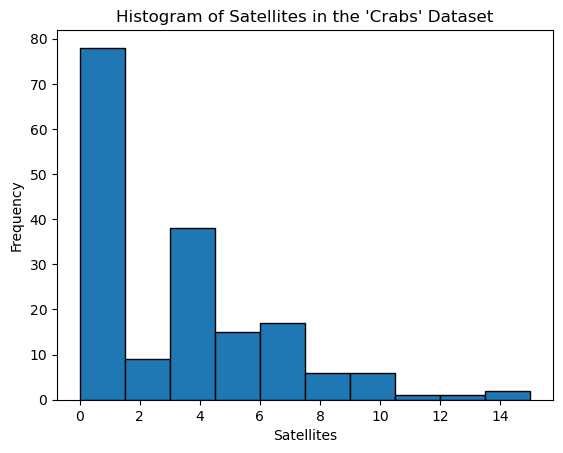

In [11]:
import matplotlib.pyplot as plt
plt.hist(crabs["Satellites"], bins=10, edgecolor="k")
plt.xlabel("Satellites")
plt.ylabel("Frequency")
plt.title("Histogram of Satellites in the 'Crabs' Dataset")
plt.show()

We first try to fit a Possion regression model. We need to factorize the categrical variables. 

In [12]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = crabs.Satellites

X = crabs.drop(columns = 'Satellites')
X = pd.get_dummies(X, columns = ['Dark', 'GoodSpine'], dtype = int)
X = sm.add_constant(X)

model = sm.GLM(y, X, family = sm.families.Poisson())
results = model.fit()

y_pred = results.predict(X)
MSE = mean_squared_error(y, y_pred)
print(MSE)

8.802038936688186


How I do know whether my fit is good or bad, besides of comparing the MSE? We can also plot the residual plots and calculate the overdispersion.

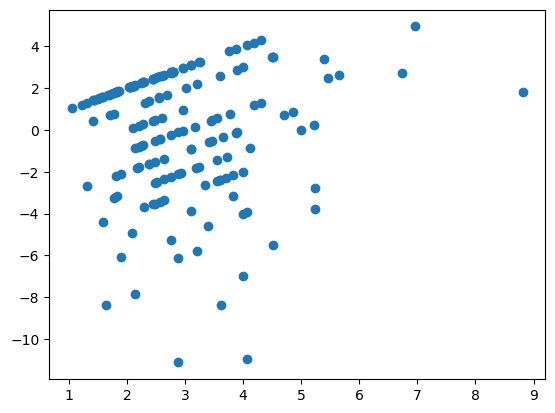

In [13]:
errors = y_pred - y
plt.scatter(y_pred, errors)

In [14]:
# Check for overdispersion using the Pearson chi-squared test
test_value = results.pearson_chi2/results.df_resid
test_value

3.221323825512474

You can consider the overdispersion value we calculate here is the indicates whether there is residuals in the model that cannot be explained by the model. The general steps is:

1. Fit the count data model (e.g., Poisson regression) to the data.
2. Calculate the Pearson chi-squared statistic, which measures the difference between the observed and expected frequencies based on the fitted model.
3. Compare the chi-squared statistic to a chi-squared distribution with an appropriate degree of freedom (usually the residual degrees of freedom from the model) to determine if the discrepancy between observed and expected frequencies is statistically significant.

If the value is larger than 1, it means overdispersion and it is not a good fit. If the value is approximate equal to 1 or less than 1, it can be considered as a good fit. 

In [15]:
# Fit a negative binomial regression model
model = sm.GLM(y, X, family = sm.families.NegativeBinomial())
results = model.fit()

y_pred = results.predict(X)
MSE = mean_squared_error(y, y_pred)
print(MSE)

9.007325370832818


C:\Users\yangx\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [16]:
test_value = results.pearson_chi2/results.df_resid
test_value

0.9464810047590325

#### Fit Gamma model

Now suppose out target value is the width, which is a continous value. Again, first observe the histogram:

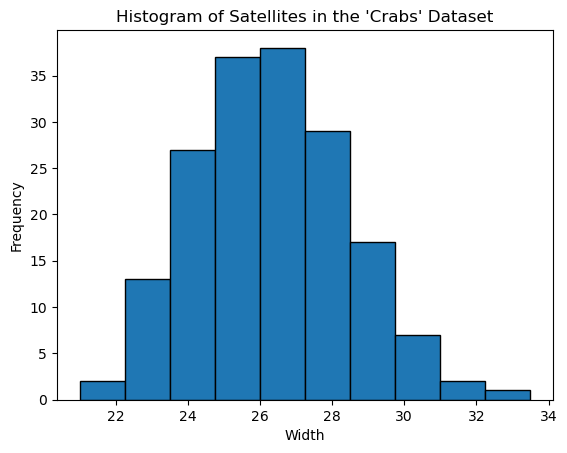

In [22]:
plt.hist(crabs["Width"], bins=10, edgecolor="k")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Histogram of Satellites in the 'Crabs' Dataset")
plt.show()

In [19]:
y = crabs.Width

X = crabs.drop(columns = 'Width')
X = pd.get_dummies(X, columns = ['Dark', 'GoodSpine'], dtype = int)
X = sm.add_constant(X)

model = sm.GLM(y, X, family = sm.families.Gamma(link = sm.families.links.log()))
results = model.fit()

y_pred = results.predict(X)
MSE = mean_squared_error(y, y_pred)
print(MSE)

3.7308669012693354


If you are interested in what link options you can have, see the help page: https://www.statsmodels.org/stable/glm.html